# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построем модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# Определение возраста покупателей

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import os

## Исследовательский анализ данных

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
display(df)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


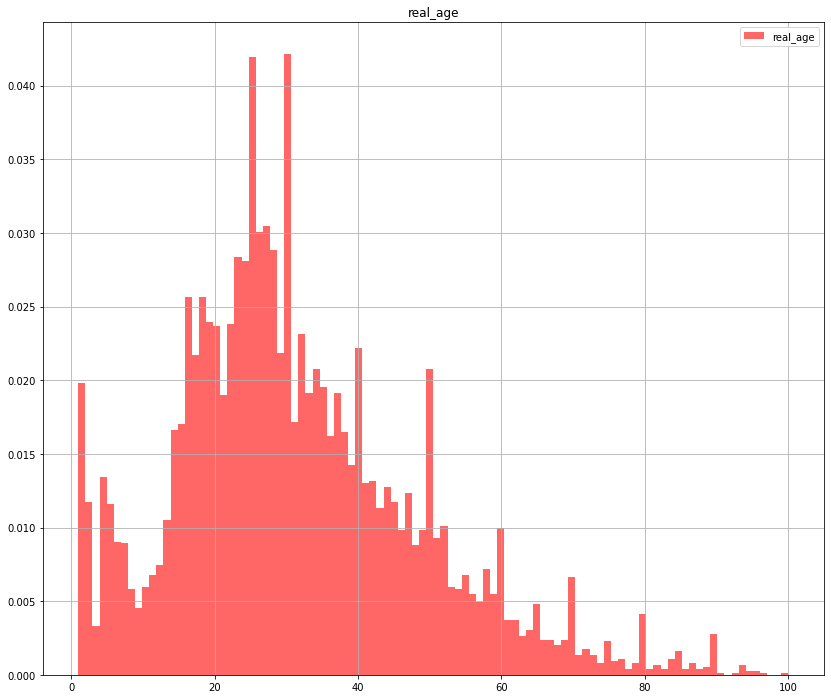

In [3]:
df.hist(bins=100, density=True, label='real_age', alpha=0.6, color='red',figsize=(14,12))
plt.legend();

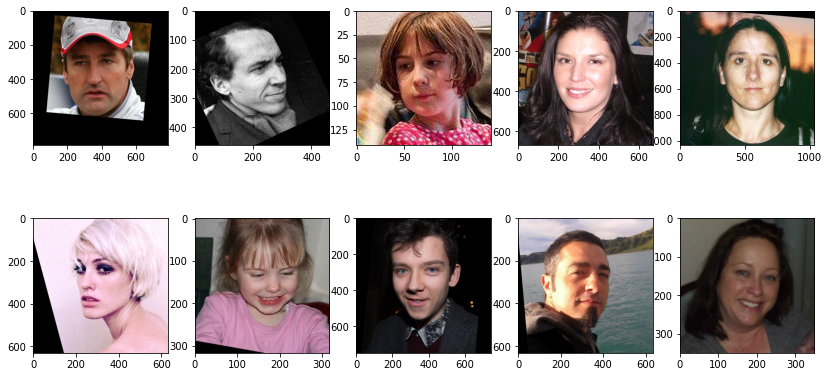

In [4]:
src_path = "/datasets/faces//final_files"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(14,7))
for e in range(len(sub_class[0:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img)

Вывод: 

- Размер датасета (7591,2), думаю такого колличества фотографии достаточно для решения нашей задачи;

- Минимальный возраст фотографии от 1 года и максимальный до 100 лет. Фотографии распределены так что очень много фото людей от 10 до 50 лет. Также виден всплеск количества фото в юбилейные годы

- Из данных видно, что не все фотографий одинакового качества, есть черно-белые, где фото сделано не в профиль а сбоку, где люди на фоне чего либо. Но стоить отметить что все фото сделаны крупным планом и это очень хорошо.

- Для улучшения качества, можно было некоторые фотографии повернуть, чтобы установить лица горизонатльно.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)
 
    return train_datagen_flow
    
def load_test(path):  
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)
 
    return test_datagen_flow
    
    
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)                
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
 
    return model    
    
   
    
def train_model(model, train_data, test_data, batch_size= None, epochs=10,
                 steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 70s - loss: 206.1592 - mae: 10.4077 - val_loss: 704.7446 - val_mae: 21.5682
Epoch 2/10
356/356 - 39s - loss: 82.5026 - mae: 6.9024 - val_loss: 153.8737 - val_mae: 9.3454
Epoch 3/10
356/356 - 39s - loss: 54.9763 - mae: 5.7191 - val_loss: 78.0454 - val_mae: 6.6547
Epoch 4/10
356/356 - 38s - loss: 42.3677 - mae: 4.9539 - val_loss: 70.6814 - val_mae: 6.3203
Epoch 5/10
356/356 - 38s - loss: 34.5198 - mae: 4.4952 - val_loss: 73.6005 - val_mae: 6.3755
Epoch 6/10
356/356 - 38s - loss: 24.7845 - mae: 3.8381 - val_loss: 74.0655 - val_mae: 6.5343
Epoch 7/10
356/356 - 38s - loss: 19.2761 - mae: 3.3800 - val_loss: 66.0125 - val_mae: 5.9671
Epoch 8/10
356/356 - 38s - loss: 17.2432 - mae: 3.1162 - val_loss: 66.4581 - val_mae: 6.1079
Epoch 9/10
356/356 - 38s - loss: 15.1312 - mae: 2.9626 - val_loss: 70.9834 - val_mae: 6.1903
Epoch 10/10
356/356 - 38s - loss: 14.3257 - mae: 2.8501 - val_loss: 61.5927 - val_mae: 5.9209

119/119 - 10s - loss: 62.1020 - mae: 5.9436
Test MAE: 5.9436

```

## Анализ обученной модели

Вывод: 
- Использовали ResNet50, также алгоритм Adam, загрузили предобученные веса imagenet.
- Параметры обучения: размер батча = 16, заморозка весов бэкбона не использовалась, было 10 эпох.
- Обучили модель и получили MAE = 5,9436